**Last Updated**: *7 May 2025*

**CNN Auto-Encoder**

In [31]:
# === Modules ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [2]:
# === Load data ===
normal_data = np.load('train_non_CD_features2.npy')        
cd_data = np.load('train_CD_features2.npy')                

normal_data = np.delete(normal_data, [2, 3, 6], axis=1)
cd_data = np.delete(cd_data, [2, 3, 6], axis=1)

normal_tensor = torch.tensor(normal_data, dtype=torch.float32)
cd_tensor = torch.tensor(cd_data, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(normal_tensor), batch_size=32, shuffle=True)

In [3]:
# === Functions: Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=3, stride=2, padding=1, output_padding=1),  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x[:, :, :50, :50]


In [4]:
# === Set device ===
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device will run on {device}")

Device will run on cuda


Training...
Epoch 1: Loss = 0.416018
Epoch 2: Loss = 0.346293
Epoch 3: Loss = 0.343514
Epoch 4: Loss = 0.342527
Epoch 5: Loss = 0.341852
Epoch 6: Loss = 0.341211
Epoch 7: Loss = 0.340732
Epoch 8: Loss = 0.340273
Epoch 9: Loss = 0.339897
Epoch 10: Loss = 0.339493
Time taken: 164.53 seconds


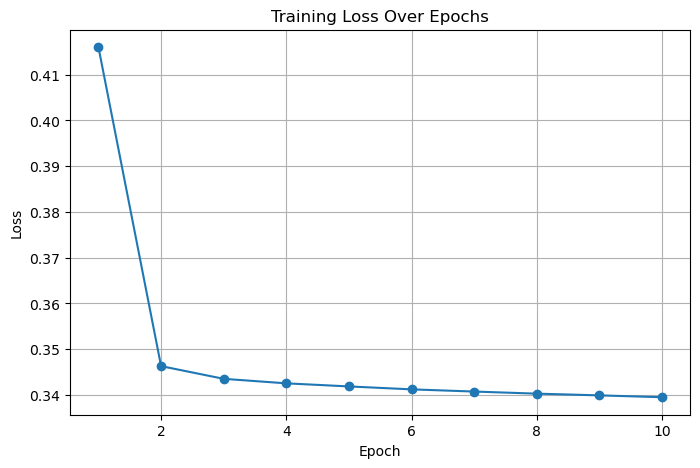

In [32]:
# === Train the model ===
model = Autoencoder().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
start_time = time.time()

print("Training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    epoch_loss = total_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.6f}")

elapsed_time = time.time() - start_time 
print(f"Time taken: {elapsed_time:.2f} seconds")

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [17]:
# === Compute reconstruction error ===
model.eval()
with torch.no_grad():
    normal_tensor = normal_tensor.to(device)
    normal_recon = model(normal_tensor)
    normal_errors = torch.mean((normal_tensor - normal_recon) ** 2, dim=[1, 2, 3]).cpu().numpy()

with torch.no_grad():
    cd_tensor = cd_tensor.to(device)
    cd_recon = model(cd_tensor)
    cd_errors = torch.mean((cd_tensor - cd_recon) ** 2, dim=[1, 2, 3]).cpu().numpy()

all_errors = np.concatenate([normal_errors, cd_errors])

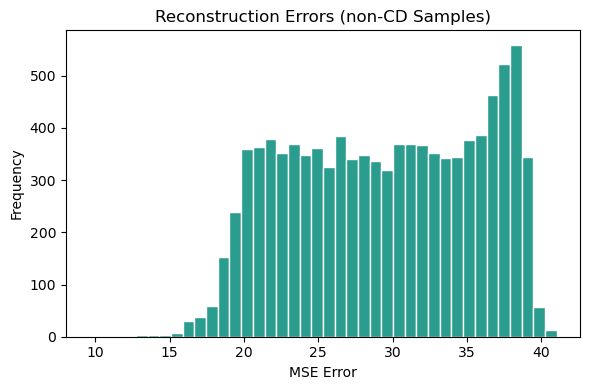

In [13]:
# === Plot normal error histogram ===
plt.figure(figsize=(6, 4))
plt.hist(normal_errors, bins=40, color='#2A9D8F', edgecolor='white')
plt.title("Reconstruction Errors (non-CD Samples)")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()

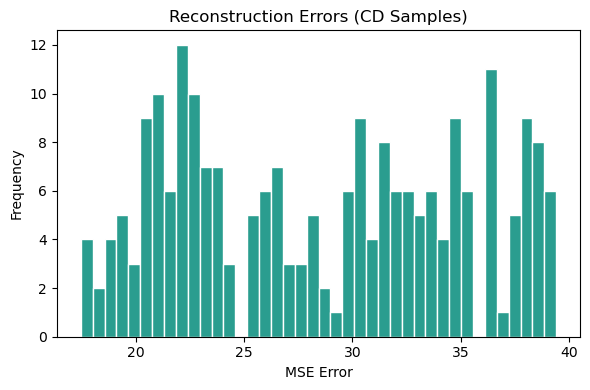

In [18]:
# === Plot CD error histogram ===
plt.figure(figsize=(6, 4))
plt.hist(cd_errors, bins=40, color='#2A9D8F', edgecolor='white')
plt.title("Reconstruction Errors (CD Samples)")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()

In [20]:
# === Flag anomalies with threshold ===
threshold = np.percentile(cd_errors, 25)
anomalies = cd_errors > threshold
print(f"Threshold (25th percentile): {threshold:.6f}")
print(f"Detected {np.sum(anomalies)} anomalies out of {len(cd_errors)} CD samples.")
normals = normal_errors > threshold
print(f"Detected {np.sum(normals)} anomalies out of {len(normal_errors)} non-CD samples.")

Threshold (25th percentile): 22.525434
Detected 167 anomalies out of 223 CD samples.
Detected 8190 anomalies out of 9993 non-CD samples.


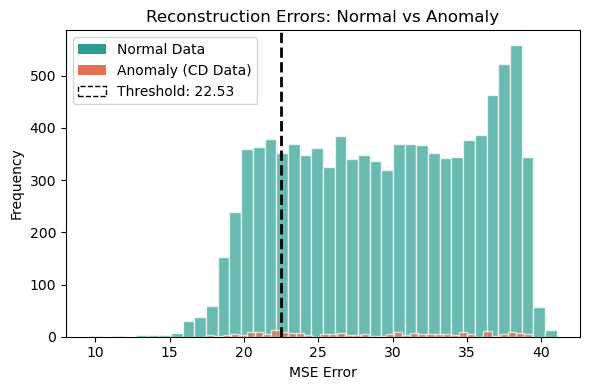

In [21]:
# === Plot histogram with threshold ===
plt.figure(figsize=(6, 4))

plt.hist(normal_errors, bins=40, color='#2A9D8F', edgecolor='white', alpha=0.7, label='Normal Data')
plt.hist(cd_errors, bins=40, color='#E76F51', edgecolor='white', alpha=0.7, label='Anomaly (CD Data)')
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.2f}')

legend_elements = [
    Patch(facecolor='#2A9D8F', label='Normal Data'),
    Patch(facecolor='#E76F51', label='Anomaly (CD Data)'),
    Patch(facecolor='none', edgecolor='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
]
plt.legend(handles=legend_elements)

plt.title("Reconstruction Errors: Normal vs Anomaly")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()

Validation summary:
    Detected 167 anomalies out of 223 CD samples.
    Detected 8190 anomalies out of 9993 non-CD samples.

Accuracy: 0.1928
Precision: 0.0200
Recall: 0.7489
F1 Score: 0.0389


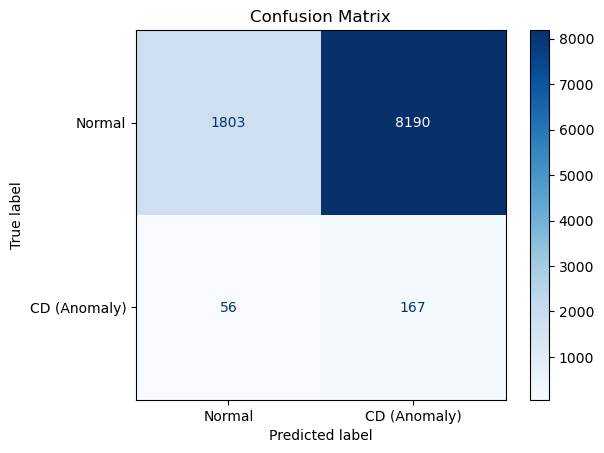

In [ ]:
# === Compute metrics ===
y_true = np.array([0] * len(normal_errors) + [1] * len(cd_errors))
y_pred = np.concatenate([
    (normal_errors > threshold).astype(int),
    (cd_errors > threshold).astype(int)
])

print(f"Validation summary:")
print(f"    Detected {np.sum(y_pred[len(normal_errors):])} anomalies out of {len(cd_errors)} CDs")
print(f"    Detected {np.sum(y_pred[:len(normal_errors)])} anomalies out of {len(normal_errors)} non-CDs")

# === Compute Metrics ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# === Plot Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "CD (Anomaly)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [25]:
# === Test data ===
unseen_CD_data = np.load("test_CD_features2.npy")
unseen_CD_data = np.delete(unseen_CD_data, [2, 3, 6], axis=1)
unseen_CD_tensor = torch.tensor(unseen_CD_data, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    recon_unseen_CD = model(unseen_CD_tensor)
    errors_unseen_CD = torch.mean((unseen_CD_tensor - recon_unseen_CD) ** 2, dim=[1, 2, 3]).cpu().numpy()

anomalies_CD = errors_unseen_CD > threshold
print(f"Detected {np.sum(anomalies_CD)} anomalies out of {len(errors_unseen_CD)} CD samples.")

unseen_normal_data = np.load("test_non-CD_features2.npy")
unseen_normal_data = np.delete(unseen_normal_data, [2, 3, 6], axis=1)
unseen_normal_tensor = torch.tensor(unseen_normal_data, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    recon_unseen_normal = model(unseen_normal_tensor)
    errors_unseen_normal = torch.mean((unseen_normal_tensor - recon_unseen_normal) ** 2, dim=[1, 2, 3]).cpu().numpy()

anomalies_normal = errors_unseen_normal > threshold
print(f"Detected {np.sum(anomalies_normal)} anomalies out of {len(errors_unseen_normal)} non-CD samples.")

Detected 37 anomalies out of 68 CD samples.
Detected 462 anomalies out of 508 non-CD samples.


Testing summary:
    Detected 37 anomalies out of 68 CDs
    Detected 462 anomalies out of 508 non-CDs

Accuracy: 0.1441
Precision: 0.0741
Recall: 0.5441
F1 Score: 0.1305


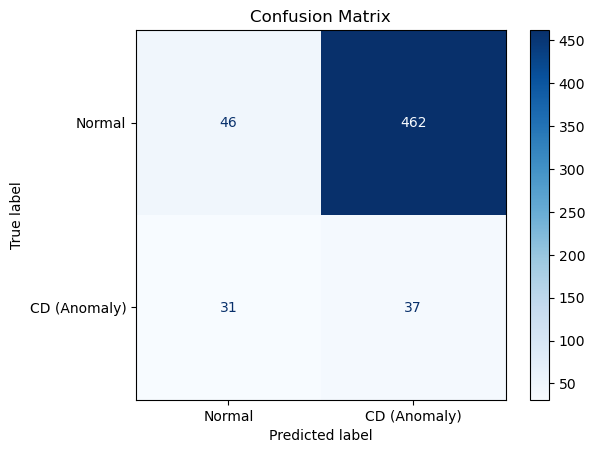

In [33]:
# === Compute metrics ===
y_true = np.array([0] * len(errors_unseen_normal) + [1] * len(errors_unseen_CD))
y_pred = np.concatenate([
    (errors_unseen_normal > threshold).astype(int),
    (errors_unseen_CD > threshold).astype(int)
])

print(f"Testing summary:")
print(f"    Detected {np.sum(y_pred[len(errors_unseen_normal):])} anomalies out of {len(errors_unseen_CD)} CDs")
print(f"    Detected {np.sum(y_pred[:len(errors_unseen_normal)])} anomalies out of {len(errors_unseen_normal)} non-CDs")

# === Compute Metrics ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# === Plot Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "CD (Anomaly)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


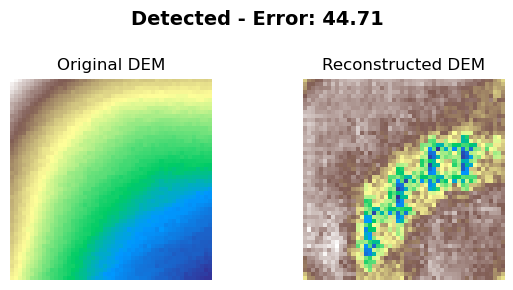

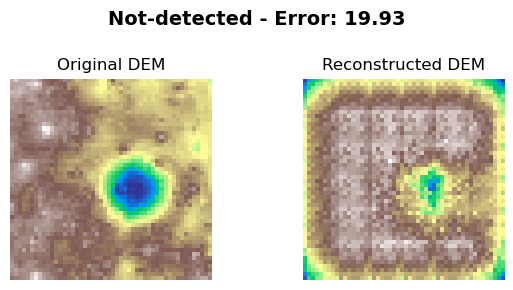

In [26]:
# === Plot one detected anomaly and one not-detected sample ===
anomalous_idx = np.where(anomalies_CD)[0][0]
not_anomalous_idx = np.where(~anomalies_CD)[0][0]

for idx, label in zip([anomalous_idx, not_anomalous_idx], ['Detected', 'Not-detected']):
    error_value = errors_unseen_CD[idx]
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f"{label} - Error: {error_value:.2f}", fontsize=14, fontweight='bold')
    axes[0].imshow(unseen_CD_tensor[idx][0].cpu(), cmap='terrain')
    axes[0].set_title("Original DEM")
    axes[1].imshow(recon_unseen_CD[idx][0].cpu(), cmap='terrain')
    axes[1].set_title("Reconstructed DEM")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()
    plt.close()
